<a href="https://colab.research.google.com/github/dgon0420/APS360Project/blob/master/Progress_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---


Authors: 
---
GONZALES, Daryl Junnel - 1002953422
---
XU, Haitong - 1002144841
---


---


# LEARNING

From our progress report with the TA, we had learned :

1. It would be helpful to include some baseline model or comparison to make sure that our model, and idea is valid. We included this by trying out a nearest neighbor model with cosine similarity and euclidean distance to validate our model. This way, we can ensure that we are getting a better accuracy than these simplistic models and that machine learning was indeed necessary.
2. He did not have much to say about our network as he was not competely knowledgeable about Siamese Networks. Therefore, no change was made in terms of what architecture was used and what processes were done to clean the data from what was originally planned. He did, however, tell us to use a network without weight sharing, that is, to feed the pokemon data one at a time like we normally do instead of two at a time like we do for Siamese Networks. This will help us fulfill the same objective as the baseline model.
3. When implementing the architecture, there was confusion as to how we are able to incorporate the main use of Siamese Networks, which is one-shot image recognition for **similarity** purposes. When we raised this concern to our TA, he was not able to offer any valuable insight or suggestions, therefore we had decided to try something that we had not done in class. We employed a two-step model: a) an autoencoder to reconstruct the winning pokemon which gets fed into a b) classifier of the winning pokemon (0/1; with 0 being the first pokemon and 1 being the second). This will be trained for validity.

From this, we had applied the following in our project and trained the network to our abilities.


---




# DATA COLLECTION
## Google Colab Commands for File Upload From Google Drive via PyDrive

In [0]:
####################### UPLOAD FILE FROM DRIVE ##########################
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 19.8MB/s 


In [0]:
# The shareable links for all the files
# COMBATS
link1 = 'https://drive.google.com/open?id=1TIeX5Hm-kwAgndl6yz_MbDkday-46RpU' 
fluff, id1 = link1.split('=')
downloaded = drive.CreateFile({'id':id1}) 
downloaded.GetContentFile('combats.csv')

# IMAGES
link2 = 'https://drive.google.com/open?id=1KasWhEQ-8sJlTSTLiS6gIFnzyPZYMd1d'
fluff, id2 = link2.split('=')
downloaded = drive.CreateFile({'id':id2}) 
downloaded.GetContentFile('images.zip')

# ATTRIBUTES
link3 = 'https://drive.google.com/open?id=1JHGWhuOU2wT2eIF_uO6PI68UkLsvAEty'
fluff, id3 = link3.split('=')
downloaded = drive.CreateFile({'id':id3}) 
downloaded.GetContentFile('pokemon.csv')

# STRENGTH
link4 = 'https://drive.google.com/open?id=1YtCcrBrIrBAHhtp7LxBiaWsDEGMOdzEw'
fluff, id4 = link4.split('=')
downloaded = drive.CreateFile({'id':id4}) 
downloaded.GetContentFile('strength.csv')

# TESTS
link5 = 'https://drive.google.com/open?id=1zagBB5xEQaMO-3eH6Yk4zebkLzJ-2aqo'
fluff, id5 = link5.split('=')
downloaded = drive.CreateFile({'id':id5}) 
downloaded.GetContentFile('tests.csv')

In [0]:
# Importing necessary libraries
import csv
import numpy as np
import random
import torch
import torch.utils.data
import pandas as pd
import io
import zipfile
import matplotlib.pyplot as plt

## Loading Sources of Data

In [0]:
attributes = pd.read_csv('pokemon.csv')
strengths = pd.read_csv('strength.csv')
combat_history = pd.read_csv('combats.csv')
test = pd.read_csv('tests.csv')
images = zipfile.ZipFile(('images.zip'), 'r')
images.extractall()

## Visualizing the Different Datasets
### Attributes Dataset
This dataset contains the basic stats and attributes of 800 pokemons, and can be divided into continuous and categorical features.

#### Continuous Features
The continuous features in this dataset include:
1. HP (hit points)
2. Attack	
3. Defense	
4. Special Attack
5. Special Defense	
6. Speed

#### Categorical Features
The categorical features in this dataset include:
1. Type 1 (primary type)
2. Type 2 (secondary type)
3. Generation (1-6,  depending on stage of evolution)
4. Legendary status

In [0]:
(row, col) = attributes.shape
print('There are {} pokemons in the attributes dataset.'.format(row))
attributes[:5]

There are 800 pokemons in the attributes dataset.


,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


### Strengths Dataset
This dataset contains  how each pokemon fares when dealing against attacks from all the other types of pokemons in 0.5 increments.

1. 0.5 - Weak
2. 1.0 - Normal 
3. 1.5 - Strong
4. 2.0 - Impervious

In [0]:
(row, col) = strengths.shape
print('There are {} pokemons in the strengths dataset.'.format(row))
strengths[:5]

There are 801 pokemons in the strengths dataset.


,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


### Combat History Dataset
Simple dataset containing 1v1 pokemon battles and the respective winners from those matches. The numbers for these pokemons correspond to the indexn number '#' in the ```attributes``` dataset. 



In [0]:
(row, col) = combat_history.shape
print('There are {} matches in the combat_history dataset.'.format(row))
combat_history[:5]

There are 50000 matches in the combat_history dataset.


,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [0]:
!pip install Unidecode

    100% |████████████████████████████████| 245kB 7.3MB/s 


||  MATCH 21


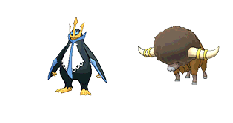

||   Empoleon  vs  Bouffalant
||   Winner: Bouffalant
|| =============================
||  MATCH 22


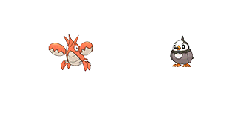

||   Corphish  vs  Starly
||   Winner: Starly
|| =============================
||  MATCH 23


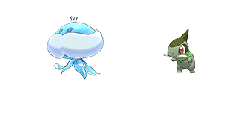

||   Jellicent  vs  Axew
||   Winner: Axew
|| =============================
||  MATCH 24


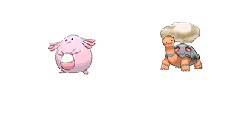

||   Chansey  vs  Torkoal
||   Winner: Chansey
|| =============================
||  MATCH 25


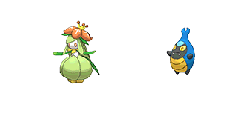

||   Lilligant  vs  Karrablast
||   Winner: Karrablast
|| =============================


In [0]:
from unidecode import unidecode as dec
for i in range(20,25):
    first = combat_history['First_pokemon'][i]
    first = attributes['Name'][int(first)]
    second = combat_history['Second_pokemon'][i]
    second = attributes['Name'][int(second)]
    winner = combat_history['Winner'][i]
    winner = attributes['Name'][int(winner)]
    
    contenders = [(plt.imread('images/' + dec(first.lower().replace(' ', '-')) 
                              + '.png')), 
                  (plt.imread('images/' +  dec(second.lower().replace(' ', '-')) 
                              + '.png'))]
    print("||  MATCH {}".format(i+1))
    fig = plt.figure(figsize=(3.5,2))
    for j, image in enumerate(contenders):
        sub = fig.add_subplot(1, len(contenders), j+1)
        plt.axis('off')
        plt.imshow(image)
    plt.show()
    print("||   {}  vs  {}".format(first, second))
    print("||   Winner: {}".format(winner))
    print("|| =============================")

## Data Cleaning
### Cleaning the Attributes Dataset
#### Headers
Making the headers consistent by having them all lowercase without any spaces would make for easier manipulation of the dataframe.

In [0]:
attributes.columns = ['index', 'name', 'type1', 'type2', 'hp', 'attack', 
                      'defense', 'spatk', 'spdef', 'speed', 'generation',
                      'legendary']

#### Deleting Pokemons not in the Pokedex
The Pokedex is the standard Pokemon database that contains the officially registered Pokemons throughout the different generations (iterations of the franchise through years of release). The **```combats```** and **```attributes```** datasets contain Pokemons that are not in the Pokedex, and instead are special types that are featured only in promotional content. These special Pokemons also do not exist in the games that we are interested in.

In [0]:
name1 = list(attributes['name'])
name2 = list(strengths['name'])
not_in_pokedex = []
for i in range(len(name1)):
    if name1[i] not in name2:
        not_in_pokedex.append(i)
attribute_df = attributes.drop(not_in_pokedex, axis = 0)

In [0]:
for i in range(5):
    print('{} is not in the dataset anymore.'.format(attributes['name'][not_in_pokedex[i]]))

Mega Venusaur is not in the dataset anymore.
Mega Charizard X is not in the dataset anymore.
Mega Charizard Y is not in the dataset anymore.
Mega Blastoise is not in the dataset anymore.
Mega Beedrill is not in the dataset anymore.


#### Normalizing Continuous Features
We want to normalize each of the continuous features so that we can get better results with our neural network. 

In [0]:
contin = ['hp', 'attack', 'defense', 'spatk', 'spdef', 'speed']
for feat in contin:
    min_val = attribute_df[feat].min()
    max_val = attribute_df[feat].max()
    diff = max_val - min_val
    
    attribute_df.loc[:, [feat]] = (attribute_df[feat] - min_val)/diff

#### One-hot Encoding of Categorical Features
We will use the ```get_dummies``` function in ```pandas``` in order to get a one-hot encoding of the categorical features. We will also remove the names of the Pokemons, make it so that the continuous features come before the categorical features, and set the ```index``` column to be the actual index of the dataframe to avoid redundancy. 

In [0]:
categ = ['type1', 'type2', 'legendary']
features = ['index'] + contin + categ
attr_df = attribute_df[features]
attr_df = pd.get_dummies(attr_df, prefix = categ, columns = categ)
attr_df.set_index('index', inplace = True)
print('There are now only {} remaining with {} removed.'.format(
        attr_df.shape[0], len(not_in_pokedex)))
attr_df[:5]

There are now only 704 remaining with 96 removed.


,hp,attack,defense,spatk,spdef,speed,type1_Bug,type1_Dark,type1_Dragon,type1_Electric,...,type2_Ground,type2_Ice,type2_Normal,type2_Poison,type2_Psychic,type2_Rock,type2_Steel,type2_Water,legendary_False,legendary_True
index,,,,,,,,,,,,,,,,,,,,,
1,0.173228,0.27500,0.195556,0.381944,0.214286,0.258065,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0.232283,0.35625,0.257778,0.486111,0.285714,0.354839,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0.311024,0.48125,0.346667,0.625000,0.380952,0.483871,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
5,0.149606,0.29375,0.168889,0.347222,0.142857,0.387097,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
6,0.224409,0.36875,0.235556,0.486111,0.214286,0.483871,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [0]:
column = attr_df.columns
labels = set(column)
count = 0
for label in labels:
    if 'type1_' in label:
        count += 1
print('There are {} primary types of Pokemons under "type1".'.format(count))

There are 18 primary types of Pokemons under "type1".


### Aggregating the Attributes and Strengths Datasets
From the **```strengths```** dataset, we will get the features that denote how strong each Pokemon is against all the other types and concatenate this to our attributes dataset, **```attr_df```**. 

In [0]:
column = strengths.columns
labels = set(column)
str_col = []
str_col = [label for label in labels if 'against_' in label]
str_col = sorted(str_col)
print("Does the number of types in the strengths dataset match the attributes?")
print('{}, there are {} types in both.'.format((len(str_col) == count), count))

Does the number of types in the strengths dataset match the attributes?
True, there are 18 types in both.


#### Deleting the Extra Pokemons
SInce we know that the number of Pokemons in the ```attributes``` dataset became reduced when the special Pokemons were removed, we want this to match and correspond to the ```strengths``` datasets.

In [0]:
names = list(attribute_df['name'])
not_in_attributes = []
for i in range(len(name2)):
    if (name2[i]).lower() not in [name.lower() for name in names]:
        not_in_attributes.append(i)
        
strengths_df = strengths.drop(not_in_attributes, axis = 0)

#### Concatenating the two datasets
Now, we want to get only the columns that we need under the ```against_``` + type of Pokemon. Therefore we get this from the  strengths dataset and concatenate this to **```attr_df```**. 

In [0]:
str_df = strengths_df[str_col]

# Making sure the two datasets have the same number of rows
str_df.shape[0] == attr_df.shape[0]

True

In [0]:
str_df = str_df.set_index(attr_df.index.values)
poke_df = pd.concat([attr_df, str_df], axis = 1)
print('The concatenated dataset becomes:')
poke_df.head(5)

The concatenated dataset becomes:


,hp,attack,defense,spatk,spdef,speed,type1_Bug,type1_Dark,type1_Dragon,type1_Electric,...,against_ghost,against_grass,against_ground,against_ice,against_normal,against_poison,against_psychic,against_rock,against_steel,against_water
index,,,,,,,,,,,,,,,,,,,,,
1,0.173228,0.27500,0.195556,0.381944,0.214286,0.258065,0,0,0,0,...,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5
2,0.232283,0.35625,0.257778,0.486111,0.285714,0.354839,0,0,0,0,...,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5
3,0.311024,0.48125,0.346667,0.625000,0.380952,0.483871,0,0,0,0,...,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5
5,0.149606,0.29375,0.168889,0.347222,0.142857,0.387097,0,0,0,0,...,1.0,0.50,2.0,0.5,1.0,1.0,1.0,2.0,0.5,2.0
6,0.224409,0.36875,0.235556,0.486111,0.214286,0.483871,0,0,0,0,...,1.0,0.50,2.0,0.5,1.0,1.0,1.0,2.0,0.5,2.0


In [0]:
# Update categorical data list:
categ = categ + ['against']
print('The categorical headings now include', categ)

The categorical headings now include ['type1', 'type2', 'legendary', 'against']


### Delete the Combat History Matches with Pokemons not in Pokedex

Since we got rid of some Pokemons that are not in the Pokedex, we have to make it consistent across all datasets and delete these Pokemons from the **```combat_history```** dataset

In [0]:
# Use not_in_pokedex list from before to find the pokemons from
# the combat_history dataset and get rid of them
# Actual index of the pokemon is + 1
not_in_poke = [poke +1 for poke in not_in_pokedex]
comb_indices = []

poke1 = list(combat_history['First_pokemon'])
for i, pok1 in enumerate(poke1):
    if pok1 in not_in_poke:
        comb_indices.append(i)
        
poke2 = list(combat_history['Second_pokemon'])
for j, pok2 in enumerate(poke2):
    if pok2 in not_in_poke:
        comb_indices.append(j)
combat_df = combat_history.drop(comb_indices, axis = 0)
total = combat_df.shape[0]
combat_df = combat_df.set_index(pd.Series(range(total)))
print('The new shape of combat_history is', combat_df.shape)

The new shape of combat_history is (38839, 3)


## Splitting Dataset into Training, Validation and Testing

We want to split our combat history dataset into the training and validation and decide on the split that we want our dataset to have. Since we have 38,839 matches in our **```combat_history```** dataset, we will splt our data set into ```80-10-10```, which is a recognized training split for moderately sized datasets.

In [0]:
import random
from torch.utils import data

def split_data(pok_dataf, comb_dataf, batch_size = 1):
    '''
    Arguments:
        pok_dataf = attributes+strengths Pandas dataframe
        comb_dataf = combat_history Pandas dataframe
        batch_size = optional, default is 1
    '''   
    # Convert the pandas dataframe to a numpy array
    np_data = comb_dataf.values.astype(np.int64)

    # Get dataset indices
    data_ind = np.arange(np_data.shape[0])
    
    # Set 90-10 train-val/test split
    test_split = int(len(data_ind) * 0.90)
    
    # No shuffle for test set, consistently set to be the last 10% of the dataset
    train_val_ind, test_index = data_ind[:test_split], data_ind[test_split:]
    
    np.random.seed(10000) # set the numpy seed for consistent split
    np.random.shuffle(train_val_ind)
    
    # Set 80-10 train-val split
    split = int(len(data_ind) * 0.2)
    train_index, val_index = train_val_ind[:split], train_val_ind[split:]  

    # Get data and label using get_data function
    tra_pok1, tra_pok2, tra_pok2, tra_label = get_data(train_index, 
                                                       comb_dataf, 
                                                       pok_dataf)
    train = data.TensorDataset(tra_pok1, tra_pok2, tra_pok2, tra_label)
    train_loader = data.DataLoader(train, batch_size=batch_size, 
                                   shuffle = False)    

    # Get data and label using get_data function
    val_pok1, val_pok2, val_pok2, val_label = get_data(val_index, 
                                                       comb_dataf, 
                                                       pok_dataf)
    val = data.TensorDataset(val_pok1, val_pok2, val_pok2, val_label)
    val_loader = data.DataLoader(val, batch_size=batch_size, 
                                 shuffle = True)
    
    # Get data and label using get_data function
    test_pok1, test_pok2, test_pok2, test_label = get_data(test_index, 
                                                           comb_dataf, 
                                                           pok_dataf)
    test = data.TensorDataset(test_pok1, test_pok2, test_pok2, test_label)
    test_loader = data.DataLoader(test, batch_size=batch_size, 
                                  shuffle = False)

    return train_loader, val_loader, test_loader


def get_data(data_ind, comb_dataf, pok_dataf):
    
    # Split the Pokemon indices into different lists for the 
    # First Pokemon, Second Pokemon and the Winning Pokemon
    pok1_ind = list(comb_dataf.loc[data_ind, 'First_pokemon'].values)
    pok2_ind = list(comb_dataf.loc[data_ind, 'Second_pokemon'].values)
    pokwin_ind = list(comb_dataf.loc[data_ind, 'Winner'].values)
    
    # Get the attributes + strengths of the First Pokemon, Second Pokemon 
    # and the Winning Pokemon and convert to a torch tensor
    pok1 = torch.from_numpy(pok_dataf.loc[pok1_ind, :].values)
    pok2 = torch.from_numpy(pok_dataf.loc[pok2_ind, :].values)
    pokwin = torch.from_numpy(pok_dataf.loc[pokwin_ind, :].values)  
    
    # If the Second Pokemon wins, set label to 1
    labels = []
    for i, poke in enumerate(pokwin_ind):
        # If the First Pokemon wins, set label to 0
        if poke == pok1_ind[i]:
            labels.append(0)
        elif poke == pok2_ind[i]:
            labels.append(1)

    label = torch.tensor(labels)
    
    return pok1.float(), pok2.float(), pokwin.float(), label.float()
    

In [0]:
train_loader, val_loader, test_loader = split_data(poke_df, combat_df, 32)

In [0]:
inp1, inp2, win, label = next(iter(train_loader))
print(inp1.shape)   # First Pokemon with 62 attributes
print(inp2.shape)   # Second Pokemon with 62 attributes
print(win.shape)    # Winning Pokemon with 62 attributes exactly the 
                    # same attributes as either first or second
print(label.shape)  # 0 or 1 for first or second pokemon winner

torch.Size([32, 62])
torch.Size([32, 62])
torch.Size([32, 62])
torch.Size([32])




---


# MODEL SETUP
## Double Siamese Network Architecture
### 1. Siamese Network Autoencoder
In our forward function, we can see that the Siamese Network takes in two inputs and shares these weights across the two inputs. Our starter Siamese Network includes a 'Vanilla Autoencoder' containing a fully connected layer from the 62 columns that all pokemons have to a bottleneck layer of 32 units, after which a ReLU activation is called. Then, a hidden layer from 32 to 62 units is initiated defore a Sigmoid activation to get the values within the range of (0, 1).

Lastly, the average value of the two reconstructions are taken and will be minimized using Mean Squared Loss in our training function with the winning Pokemon's features as the target function. The output of this Siamese Network will therefore be a reconstruction of the winning Pokemon's features.

In [0]:
from torch import nn

class SiameseAutoencoder(nn.Module):
    def __init__(self):
        super(SiameseAutoencoder, self).__init__()
        self.name = "SiameseAutoencoder"
        self.encoder = nn.Sequential(
            nn.Linear(62, 32),
            nn.ReLU()            
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 62),
            nn.Sigmoid() # get to the range (0, 1)
        )

    def forward(self, x1, x2):
        x1 = x1.view(x1.shape[0], -1)
        x1 = self.encoder(x1)
#         x1 = self.decoder(x1)
        x2 = x2.view(x2.shape[0], -1)
        x2 = self.encoder(x2)
        
        res = torch.abs(x1-x2)
        res = self.decoder(res)
        
        #res = (x1+x2)/2
        
        return res

In [0]:
model1 = SiameseAutoencoder()
out1 = model1(inp1, inp2)
out1.shape

torch.Size([32, 62])

### 2. Siamese Network Classifier
The output of the autoencoder will then be fed to another Siamese Network to classify how similar the reconstruction is to the actual winner's features. The reason why we split the model into two is because Siamese Networks often measures how similar the two inputs are. Since the two inputs that we have are opposing Pokemons, our goal is not to measure how different these inputs are, but to get the winning Pokemon, and we accomplish this by using a classifier. We also have two different loss functions to optimize our results. The classifier will be passed on to a Binary Cross Entropy loss function to obtain the wanted result.

In [0]:
class SiameseClassifier(nn.Module):
    def __init__(self):
        super(SiameseClassifier, self).__init__()
        self.name = "SiameseClassifier"
        self.linear1 = nn.Sequential(
            nn.Linear(62, 32),
            nn.Sigmoid()            
        )
        self.linear2 = nn.Sequential(
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x1, x2):
        x1 = x1.view(x1.shape[0], -1)
        x1 = self.linear1(x1)
        x2 = x2.view(x2.shape[0], -1)
        x2 = self.linear1(x2)
        
        res = torch.abs(x2-x1)
        #res = res.view(res.shape[0], -1)
        res1 = self.linear2(res)
        res1 = res1.squeeze(1) # Flatten to [batch_size]
        return res1

In [0]:
model2 = SiameseClassifier()
output2 = model2(out1, win)
output2.shape

torch.Size([32])

## Training the Siamese Network

In [0]:
import time
import torch.optim as optim

def train(model1, model2, poke_dataf, comb_dataf, num_epochs=20, batch_size=32, lr=1e-4):
    train_loader, val_loader, test_loader = split_data(poke_dataf, 
                                            comb_dataf, batch_size)
    criterion1 = nn.MSELoss()
    criterion2 = nn.BCEWithLogitsLoss()
    optimizer1 = torch.optim.Adam(model1.parameters(), lr=lr)
    optimizer2 = torch.optim.Adam(model2.parameters(), lr=lr)
    
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []
    epochs = []
    
    start_time = time.time()
    for epoch in range(num_epochs):
        
        total_train_loss = 0.0
        total_corr = 0
        total_epoch = 0
        
        for poke1, poke2, win, label in train_loader:
            optimizer1.zero_grad()
            optimizer2.zero_grad()
            recon = model1(poke1, poke2)
            loss1 = criterion1(recon, win)
            total_train_loss += loss1.item()
            loss1.backward(retain_graph=True)
            
            output = model2(recon, win)
            loss2 = criterion2(output, label)
            total_train_loss += loss2.item()
            
            loss = (loss1+loss2)
            loss.backward()
            optimizer1.step()
            optimizer2.step()
            
            corr = (output > 0.0).squeeze().long() == label.long()
            total_corr += int(corr.sum().item())
            total_epoch += len(label)

        tr_acc = float(total_corr) / total_epoch
        tr_loss = float(total_train_loss) / total_epoch           
        train_acc.append(tr_acc)
        train_loss.append(tr_loss)
        
        va_acc, va_loss = evaluate(model1, model2, val_loader, criterion1, criterion2)
        val_acc.append(va_acc)
        val_loss.append(va_loss)
        epochs.append(epoch+1)
        
        print('Epoch {}: Train Loss:{:.4f}, Val Loss:{:.4f}'.format(
                                            epoch+1, 
                                            float(train_loss[-1]),
                                            float(val_loss[-1])))
        print('          Train Accuracy:{:.4f}, Val Accuracy:{:.4f}'.format(
                                            float(train_acc[-1]),
                                            float(val_acc[-1])))
            
        
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    
    plot(train_loss, val_loss, train_acc, val_acc, epochs)
        
def evaluate(model1, model2, loader, criterion1, criterion2):
    """ Evaluate the network on the validation set.

     Args:
         model: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_corr = 0
    total_epoch = 0

    for poke1, poke2, win, label in loader:
        recon = model1(poke1, poke2)
        loss1 = criterion1(recon, win)
        total_loss += loss1.item()

        output = model2(recon, win)
        loss2 = criterion2(output, label)
        total_loss += loss2.item()
        
        corr = (output > 0.0).squeeze().long() == label.long()
        total_corr += int(corr.sum().item())
        total_epoch += len(label)

    acc = float(total_corr) / total_epoch
    loss = float(total_loss) / total_epoch

    return acc, loss

def plot(train_loss, val_loss, train_acc, val_acc, num_epochs):
    plt.title("Train vs Validation Loss")
    plt.plot(num_epochs, train_loss, label="Train")
    plt.plot(num_epochs, val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(num_epochs, train_acc, label="Train")
    plt.plot(num_epochs, val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [0]:
import time
import torch.optim as optim
    
def trainSN(model, poke_dataf, comb_dataf, num_epochs=20, batch_size=32, lr=1e-4):
    train_loader, val_loader, test_loader = split_data(poke_dataf, 
                                            comb_dataf, batch_size)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []
    epochs = []
    
    start_time = time.time()
    for epoch in range(num_epochs):
        
        total_train_loss = 0.0
        total_corr = 0
        total_epoch = 0
        
        for poke1, poke2, win, label in train_loader:
            optimizer.zero_grad()
            output = model(poke1, poke2)
            loss = criterion(output, label)
            total_train_loss += loss.item()
            loss.backward()
            
#             output = model2(recon, win)
#             loss2 = criterion2(output, label)
#             total_train_loss += loss2.item()
            
#             loss = (loss1+loss2)
#              loss.backward()
#             optimizer1.step()
            optimizer.step()
            
            corr = (output > 0.0).squeeze().long() == label.long()
            total_corr += int(corr.sum().item())
            total_epoch += len(label)

        tr_acc = float(total_corr) / total_epoch
        tr_loss = float(total_train_loss) / total_epoch           
        train_acc.append(tr_acc)
        train_loss.append(tr_loss)
        
        va_acc, va_loss = evaluate1(model, val_loader, criterion)
        val_acc.append(va_acc)
        val_loss.append(va_loss)
        epochs.append(epoch+1)
        
        print('Epoch {}: Train Loss:{:.4f}, Val Loss:{:.4f}'.format(
                                            epoch+1, 
                                            float(train_loss[-1]),
                                            float(val_loss[-1])))
        print('          Train Accuracy:{:.4f}, Val Accuracy:{:.4f}'.format(
                                            float(train_acc[-1]),
                                            float(val_acc[-1])))
            
        
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    
    plot(train_loss, val_loss, train_acc, val_acc, epochs)
    
def evaluate1(model, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         model: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_corr = 0
    total_epoch = 0

    for poke1, poke2, win, label in loader:
        output = model(poke1, poke2)
        loss = criterion(output, label)
        total_loss += loss.item()

#         output = model2(recon, win)
#         loss2 = criterion2(output, label)
#         total_loss += loss2.item()
        
        corr = (output > 0.0).squeeze().long() == label.long()
        total_corr += int(corr.sum().item())
        total_epoch += len(label)

    acc = float(total_corr) / total_epoch
    loss = float(total_loss) / total_epoch

    return acc, loss

def plot(train_loss, val_loss, train_acc, val_acc, num_epochs):
    plt.title("Train vs Validation Loss")
    plt.plot(num_epochs, train_loss, label="Train")
    plt.plot(num_epochs, val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(num_epochs, train_acc, label="Train")
    plt.plot(num_epochs, val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()      


Epoch 1: Train Loss:0.0111, Val Loss:0.0108
          Train Accuracy:0.5325, Val Accuracy:0.5369
Epoch 2: Train Loss:0.0110, Val Loss:0.0108
          Train Accuracy:0.5325, Val Accuracy:0.5369
Epoch 3: Train Loss:0.0109, Val Loss:0.0107
          Train Accuracy:0.5325, Val Accuracy:0.5369
Epoch 4: Train Loss:0.0109, Val Loss:0.0107
          Train Accuracy:0.5325, Val Accuracy:0.5369
Epoch 5: Train Loss:0.0108, Val Loss:0.0106
          Train Accuracy:0.5325, Val Accuracy:0.5369
Epoch 6: Train Loss:0.0108, Val Loss:0.0106
          Train Accuracy:0.5325, Val Accuracy:0.5369
Epoch 7: Train Loss:0.0107, Val Loss:0.0105
          Train Accuracy:0.5325, Val Accuracy:0.5369
Epoch 8: Train Loss:0.0107, Val Loss:0.0105
          Train Accuracy:0.5325, Val Accuracy:0.5369
Epoch 9: Train Loss:0.0106, Val Loss:0.0104
          Train Accuracy:0.5325, Val Accuracy:0.5369
Epoch 10: Train Loss:0.0106, Val Loss:0.0104
          Train Accuracy:0.5325, Val Accuracy:0.5369
Epoch 11: Train Loss:0.0105, 

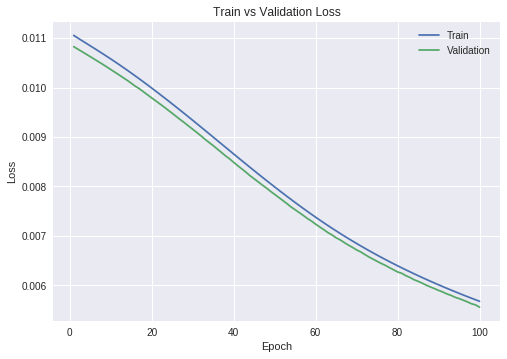

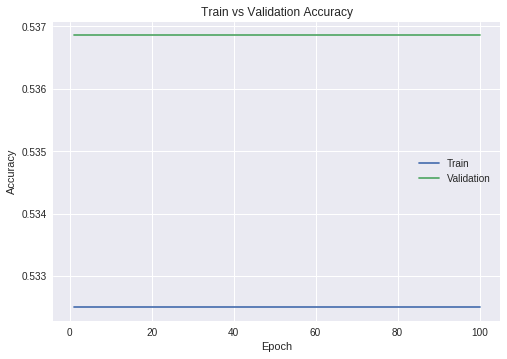

In [0]:
sub = combat_df[:10000]
model = SiameseClassifier()
trainSN(model, poke_df, sub, num_epochs=100, batch_size=64, lr=1e-4)

Epoch 1: Train Loss:1.0081, Val Loss:1.0325
          Train Accuracy:0.6667, Val Accuracy:0.6000
Epoch 2: Train Loss:1.0047, Val Loss:1.0316
          Train Accuracy:0.6667, Val Accuracy:0.6000
Epoch 3: Train Loss:1.0025, Val Loss:1.0307
          Train Accuracy:0.6667, Val Accuracy:0.6000
Epoch 4: Train Loss:1.0003, Val Loss:1.0298
          Train Accuracy:0.6667, Val Accuracy:0.6000
Epoch 5: Train Loss:0.9981, Val Loss:1.0288
          Train Accuracy:0.6667, Val Accuracy:0.6000
Epoch 6: Train Loss:0.9960, Val Loss:1.0280
          Train Accuracy:0.6667, Val Accuracy:0.6000
Epoch 7: Train Loss:0.9939, Val Loss:1.0271
          Train Accuracy:0.6667, Val Accuracy:0.6000
Epoch 8: Train Loss:0.9920, Val Loss:1.0264
          Train Accuracy:0.6667, Val Accuracy:0.6000
Epoch 9: Train Loss:0.9901, Val Loss:1.0256
          Train Accuracy:0.6667, Val Accuracy:0.6000
Epoch 10: Train Loss:0.9882, Val Loss:1.0248
          Train Accuracy:0.6667, Val Accuracy:0.6000
Epoch 11: Train Loss:0.9863, 

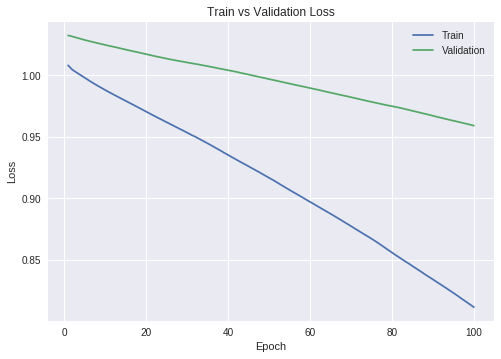

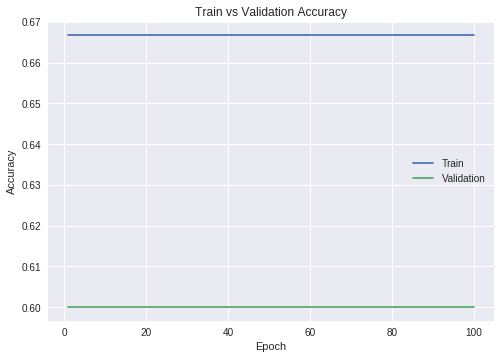

In [0]:
model1 = SiameseAutoencoder()
model2 = SiameseClassifier()
train(model1, model2, poke_df, sub, num_epochs=100, batch_size=1, lr=1e-4)

Epoch 1: Train Loss:0.0208, Val Loss:0.0096
          Train Accuracy:0.8325, Val Accuracy:0.9879
Epoch 2: Train Loss:0.0084, Val Loss:0.0076
          Train Accuracy:0.9912, Val Accuracy:0.9929
Epoch 3: Train Loss:0.0072, Val Loss:0.0068
          Train Accuracy:0.9942, Val Accuracy:0.9961
Epoch 4: Train Loss:0.0065, Val Loss:0.0063
          Train Accuracy:0.9967, Val Accuracy:0.9974
Epoch 5: Train Loss:0.0061, Val Loss:0.0059
          Train Accuracy:0.9981, Val Accuracy:0.9979
Epoch 6: Train Loss:0.0057, Val Loss:0.0056
          Train Accuracy:0.9985, Val Accuracy:0.9985
Epoch 7: Train Loss:0.0055, Val Loss:0.0054
          Train Accuracy:0.9988, Val Accuracy:0.9987
Epoch 8: Train Loss:0.0052, Val Loss:0.0051
          Train Accuracy:0.9992, Val Accuracy:0.9989
Epoch 9: Train Loss:0.0050, Val Loss:0.0050
          Train Accuracy:0.9992, Val Accuracy:0.9991
Epoch 10: Train Loss:0.0049, Val Loss:0.0049
          Train Accuracy:0.9994, Val Accuracy:0.9992
Epoch 11: Train Loss:0.0048, 

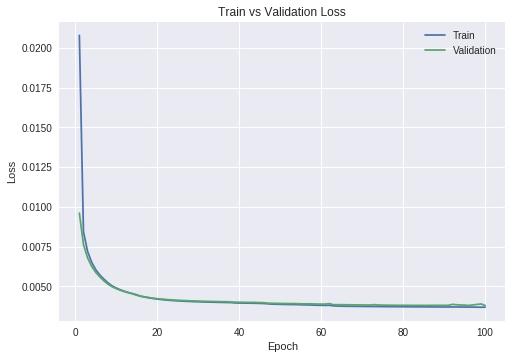

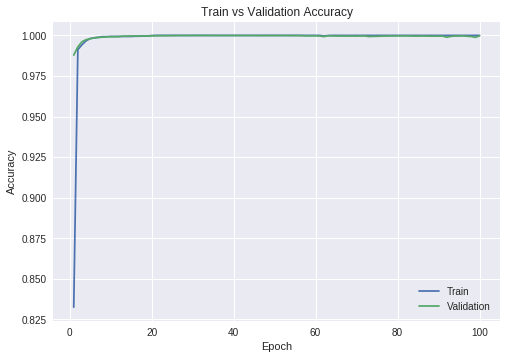

In [0]:
model1 = SiameseAutoencoder()
model2 = SiameseClassifier()
train(model1, model2, poke_df, combat_df, num_epochs=100, batch_size=32, lr=1e-3)

# Tuning hyper parameter

redefine the func

# setting up google sheet for tuning

In [0]:
!pip install --upgrade -q gspread

In [0]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

In [0]:
# open sheet in google drive
sh = gc.open_by_url('https://docs.google.com/spreadsheets/d/1Jj7nuYjObo5FL9oTKpg90dt7Ojw8g-eWrUYc3LUPpAs/edit?usp=sharing')
worksheet = sh.get_worksheet(0)

# first tune

In [0]:
b= 5 #batchsize number: 20 to 100
r= 4 # lr from 0.02 to 0.2

for i in range (b):
  batchsize=20+i*20
  worksheet.update_acell(('A{}').format(i*(r)+2),str(batchsize))
  
  for j in range(r):
      
      l_rate=0.02+j*(0.02)
      
      
      model1 = SiameseAutoencoder()
      model2 = SiameseClassifier()
      acc = train(model1, model2, poke_df, combat_df, num_epochs=50, batch_size=batchsize, lr=l_rate)
      worksheet.update_acell(('B{}').format(i*(r)+2+j),str(l_rate))
      worksheet.update_acell(('C{}').format(i*(r)+2+j),str(acc))

Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training


# second tune

In [0]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())
# open another sheet in google drive
sh = gc.open_by_url('https://docs.google.com/spreadsheets/d/1Jj7nuYjObo5FL9oTKpg90dt7Ojw8g-eWrUYc3LUPpAs/edit?usp=sharing')
worksheet1 = sh.get_worksheet(1)

In [0]:
b= 2 #batchsize number: 20 to 100
r= 5 # lr from 0.02 to 0.2

for i in range (b):
  batchsize=40+i*20
  worksheet1.update_acell(('A{}').format(i*(r)+2),str(batchsize))
  
  for j in range(r):
      
      l_rate=0.002+j*(0.002)
      
      
      model1 = SiameseAutoencoder()
      model2 = SiameseClassifier()
      acc = train(model1, model2, poke_df, combat_df, num_epochs=50, batch_size=batchsize, lr=l_rate)
      worksheet1.update_acell(('B{}').format(i*(r)+2+j),str(l_rate))
      worksheet1.update_acell(('C{}').format(i*(r)+2+j),str(acc))

Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training


# 3rd tune

In [0]:
# open another sheet in google drive
sh = gc.open_by_url('https://docs.google.com/spreadsheets/d/1Jj7nuYjObo5FL9oTKpg90dt7Ojw8g-eWrUYc3LUPpAs/edit?usp=sharing')
worksheet2 = sh.get_worksheet(2)

b= 3 #batchsize number: 50 to 80
r= 8 # lr from 0.0005 to 0.004

for i in range (b):
  batchsize=50+i*10
  worksheet2.update_acell(('A{}').format(i*(r)+2),str(batchsize))
  
  for j in range(r):
      
      l_rate=0.0005+j*(0.0005)
      
      
      model1 = SiameseAutoencoder()
      model2 = SiameseClassifier()
      acc = train(model1, model2, poke_df, combat_df, num_epochs=50, batch_size=batchsize, lr=l_rate)
      worksheet2.update_acell(('B{}').format(i*(r)+2+j),str(l_rate))
      worksheet2.update_acell(('C{}').format(i*(r)+2+j),str(acc))

Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training


# conclusion

learning rate:0.0015
batchsize:60

# tune of net

worksheet3 = sh.get_worksheet(3![alt text](https://))

In [0]:

worksheet3 = sh.get_worksheet(3)

b= 3 #batchsize number: 50 to 80
r= 8 # lr from 0.0005 to 0.004

for i in range (b):
  batchsize=50+i*10
  worksheet3.update_acell(('A{}').format(i*(r)+2),str(batchsize))
  
  for j in range(r):
      
      l_rate=0.0005+j*(0.0005)
      
      
      model1 = SiameseAutoencoder()
      model2_b = SiameseClassifier_b()
      acc = train(model1, model2_b, poke_df, combat_df, num_epochs=50, batch_size=batchsize, lr=l_rate)
      worksheet3.update_acell(('B{}').format(i*(r)+2+j),str(l_rate))
      worksheet3.update_acell(('C{}').format(i*(r)+2+j),str(acc))


Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training
Finished Training


# PLAN


So far, a model that predicts the combat winner between two Pokemons has been developed. Further algorithms that utilizing the model to select main pokemon and its synergies would be developed. Meanwhile, further adjustments and iteration on the model and algorithms will be carried to improve prediction performance. 
Detailed further tasks and internal deadline are detailed in the following table.
Project Related Tasks


Task----Deadline 

Further Tuning of Hyper Parameters----- Mar. 19, 2019 

Develop Related Functions for multiple purposes (Searching Best Synergy, Predicting Success Chance etc.) -----Mar. 21, 2019 

General Checking and Debugging-----Mar. 23, 2019 

Final Testing and Training-----Mar. 24, 2019

Course Related Tasks

Task-----Deadline 

Prepare Project Presentation Slides-----Mar. 27, 2019 

Prepare for Presentation-----TBD Prepare Final Report------April 4, 2019

In [0]:
######################## FROM ASSIGNMENT 4 ##############################
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# Build up the cat_index and cat_values dictionary
for i, header in enumerate(poke_df.keys()):
    if "_" in header: # categorical header
        feature, value = header.split('_')
        #feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of feature. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    max_num = onehot.max()
    for i, num in enumerate(onehot):
        if num == max_num:
            index = i
    
    return cat_values[feature][index]
    
def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in categ }

In [0]:
np_data = poke_df.values.astype(np.int64)
get_features(np_data[0])

{'against': 'psychic',
 'legendary': 'False',
 'type1': 'Grass',
 'type2': 'Poison'}